# Anomaly detection for time series

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tsb_kit.models.distance import Fourier
from tsb_kit.models.feature import Window
from tsb_kit.utils.slidingWindows import find_length
from tsb_kit.utils.visualisation import plotFig
from sklearn.preprocessing import MinMaxScaler

#from tsb_kit.models.norma import NORMA
from tsb_kit.models.iforest import IForest
from tsb_kit.models.lof import LOF
from tsb_kit.models.matrix_profile import MatrixProfile
from tsb_kit.models.pca import PCA
from tsb_kit.models.poly import POLY
from tsb_kit.models.ocsvm import OCSVM
from tsb_kit.models.lstm import lstm
from tsb_kit.models.AE import AE_MLP2
from tsb_kit.models.cnn import cnn
#from tsb_kit.models.series2graph import Series2Graph
from tsb_kit.models.damp import DAMP
from tsb_kit.models.sand import SAND

from tsb_kit.vus.metrics import get_metrics

##  Data preprocessing

Here we load and prepare the time series (here, we load only a snippet of 10,000 points). We asutomatically estimate the subsequence length for the anomaly detection methods that require a subsequence length parameter.
In order to do this, we use auto-correlation

In [3]:
# Prepare data for unsupervised method

filepath = '../../data/benchmark/ECG/MBA_ECG805_data.out'
df = pd.read_csv(filepath, header=None).dropna().to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1].astype(int)
    
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

data_train = data[:int(0.1*len(data))]
data_test = data

X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))

Estimated Subsequence length:  99
Time series length:  10000
Number of abnormal points:  303


## Display the results of 11 anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

AUC_ROC : 0.9796517653209067
AUC_PR : 0.5354674121425284
Precision : 1.0
Recall : 0.0462046204620462
F : 0.08832807570977919
Precision_at_k : 0.0462046204620462
Rprecision : 1.0
Rrecall : 0.1427450980392157
RF : 0.24982841455044613
R_AUC_ROC : 0.9861962693093778
R_AUC_PR : 0.6140113439366928
VUS_ROC : 0.9813282886141234
VUS_PR : 0.5943507237860649
Affiliation_Precision : 0.6162807136520358
Affiliation_Recall : 0.9999402806808003


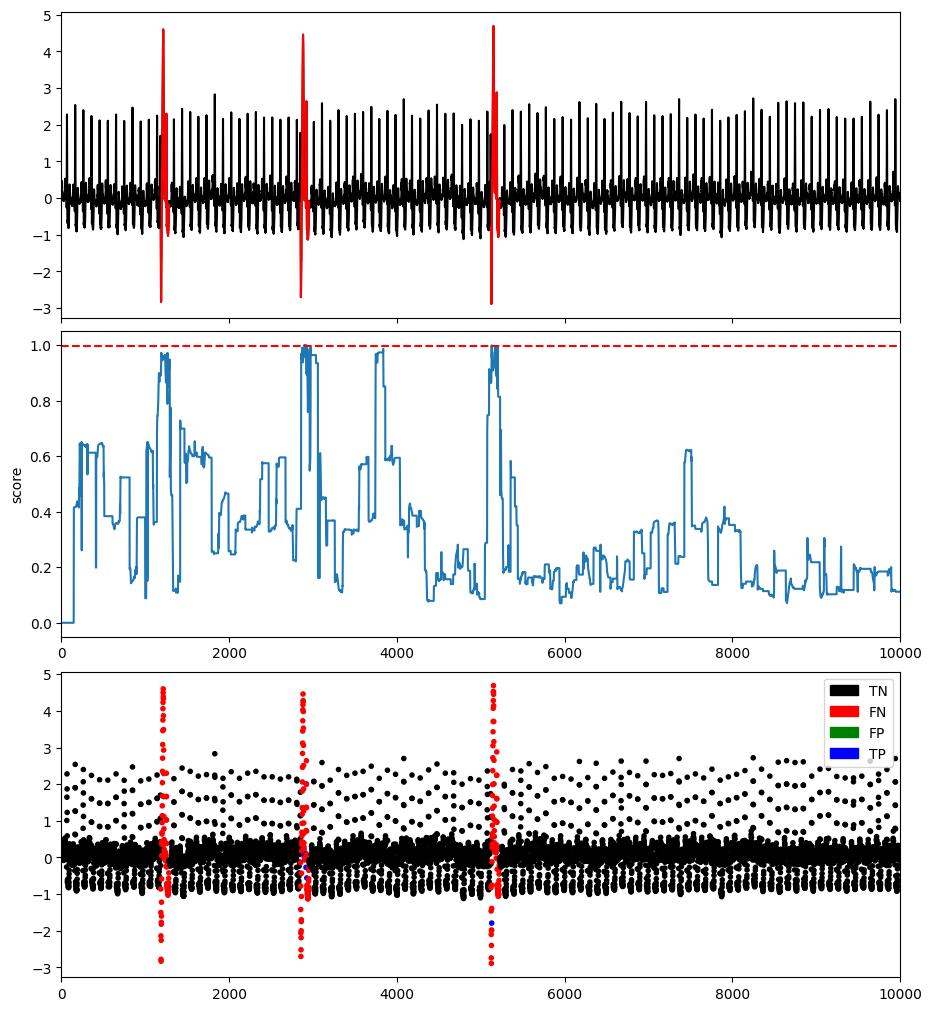

In [4]:
modelName='DAMP'
clf = DAMP(m = slidingWindow,sp_index=slidingWindow+1)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.996779310807228
AUC_PR : 0.8942079947725918
Precision : 0.7393483709273183
Recall : 0.9735973597359736
F : 0.8404558404558404
Precision_at_k : 0.9735973597359736
Rprecision : 0.7394705860012913
Rrecall : 0.9790057437116261
RF : 0.8425439890952773
R_AUC_ROC : 0.9996748675955897
R_AUC_PR : 0.9911647851406946
VUS_ROC : 0.9993050973645579
VUS_PR : 0.9802087454821152
Affiliation_Precision : 0.9825340283920497
Affiliation_Recall : 1.0


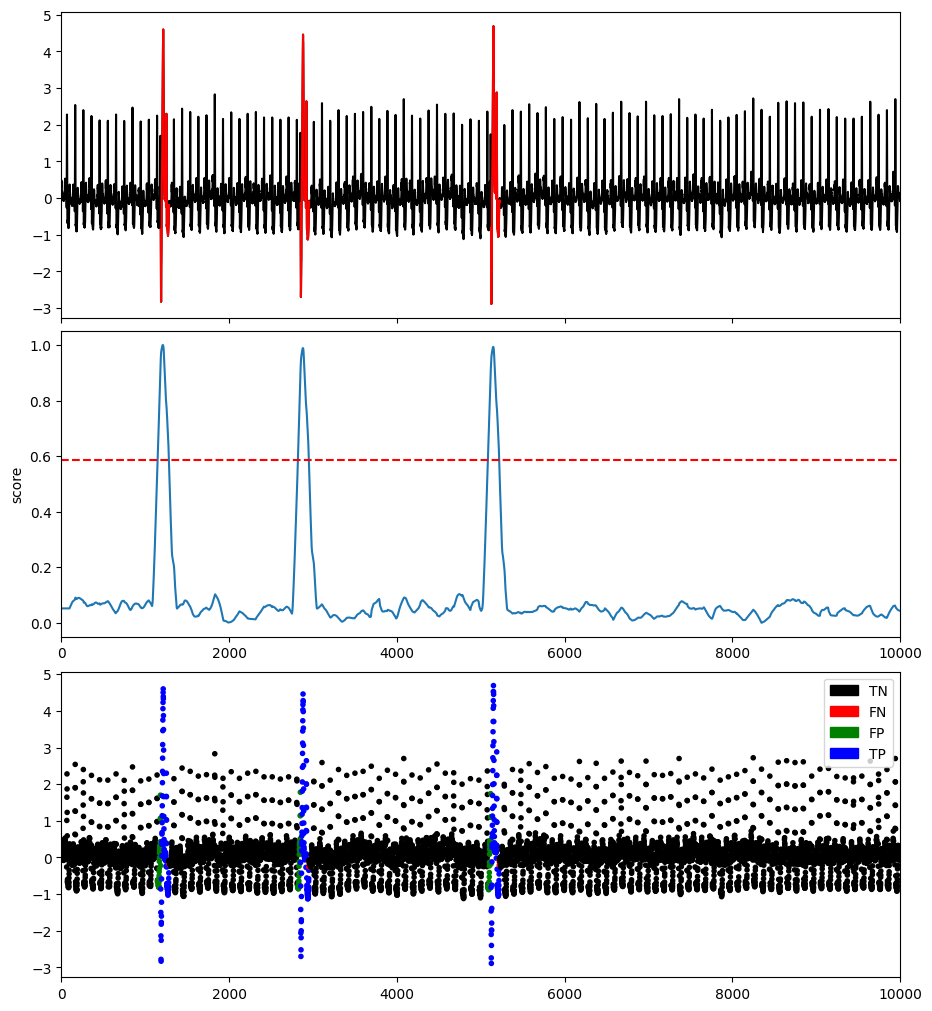

In [5]:
modelName='SAND (offline)'
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,overlaping_rate=int(1.5*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

0-->5000-->7000-->9000-->[STOP]: score length 10000
AUC_ROC : 0.9952552437877592
AUC_PR : 0.8534825713191976
Precision : 0.5897435897435898
Recall : 0.9108910891089109
F : 0.7159533073929961
Precision_at_k : 0.9108910891089109
Rprecision : 0.6257139290992594
Rrecall : 0.9290948702713409
RF : 0.747805906448152
R_AUC_ROC : 0.9984211806490199
R_AUC_PR : 0.9662017062533563
VUS_ROC : 0.9980585809756719
VUS_PR : 0.9542280349659151
Affiliation_Precision : 0.9776035535846139
Affiliation_Recall : 0.9999950659680077


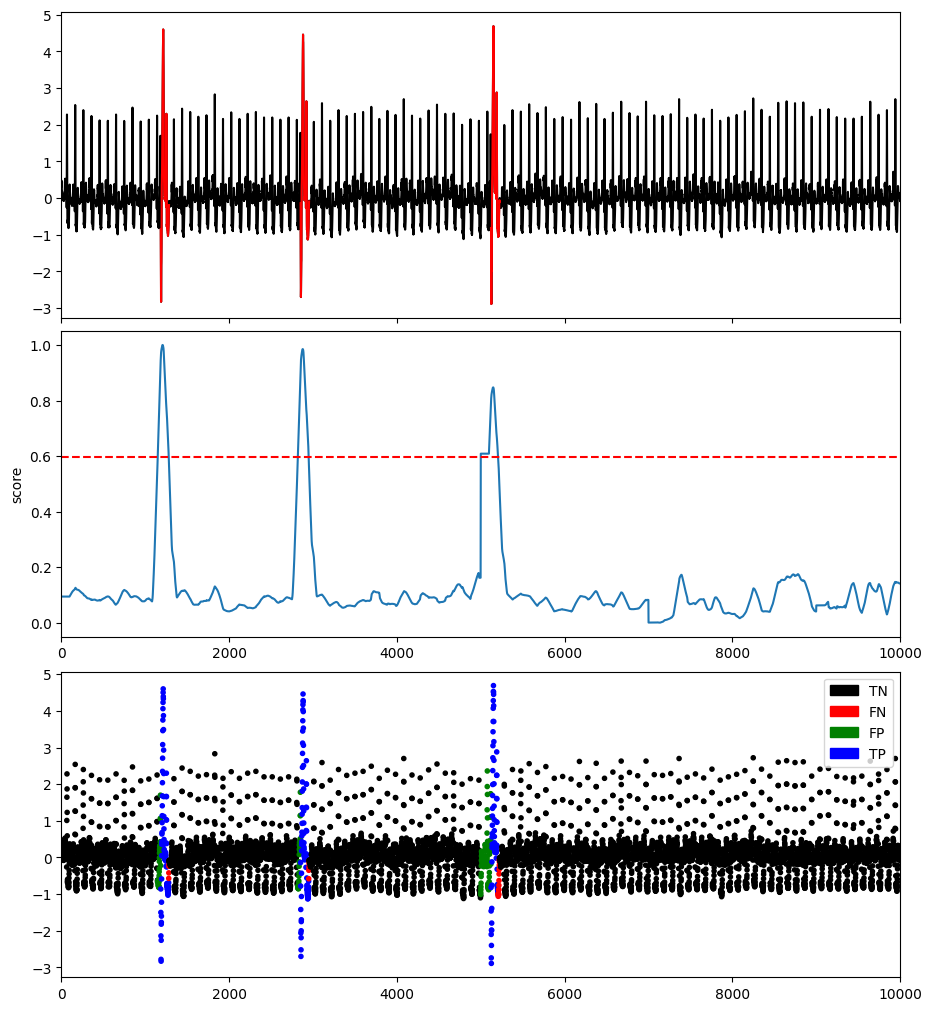

In [6]:
modelName='SAND (online)'
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,online=True,alpha=0.5,init_length=5000,batch_size=2000,verbose=True,overlaping_rate=int(4*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9791393752142049
AUC_PR : 0.8207550472208245
Precision : 0.7847222222222222
Recall : 0.7458745874587459
F : 0.7648054145516074
Precision_at_k : 0.7458745874587459
Rprecision : 0.4783287995269071
Rrecall : 0.796712220241632
RF : 0.5977696308872898
R_AUC_ROC : 0.9839017047884915
R_AUC_PR : 0.8408434964392455
VUS_ROC : 0.978472608857905
VUS_PR : 0.8203200675085416
Affiliation_Precision : 0.9282931033407741
Affiliation_Recall : 0.9989565215573869


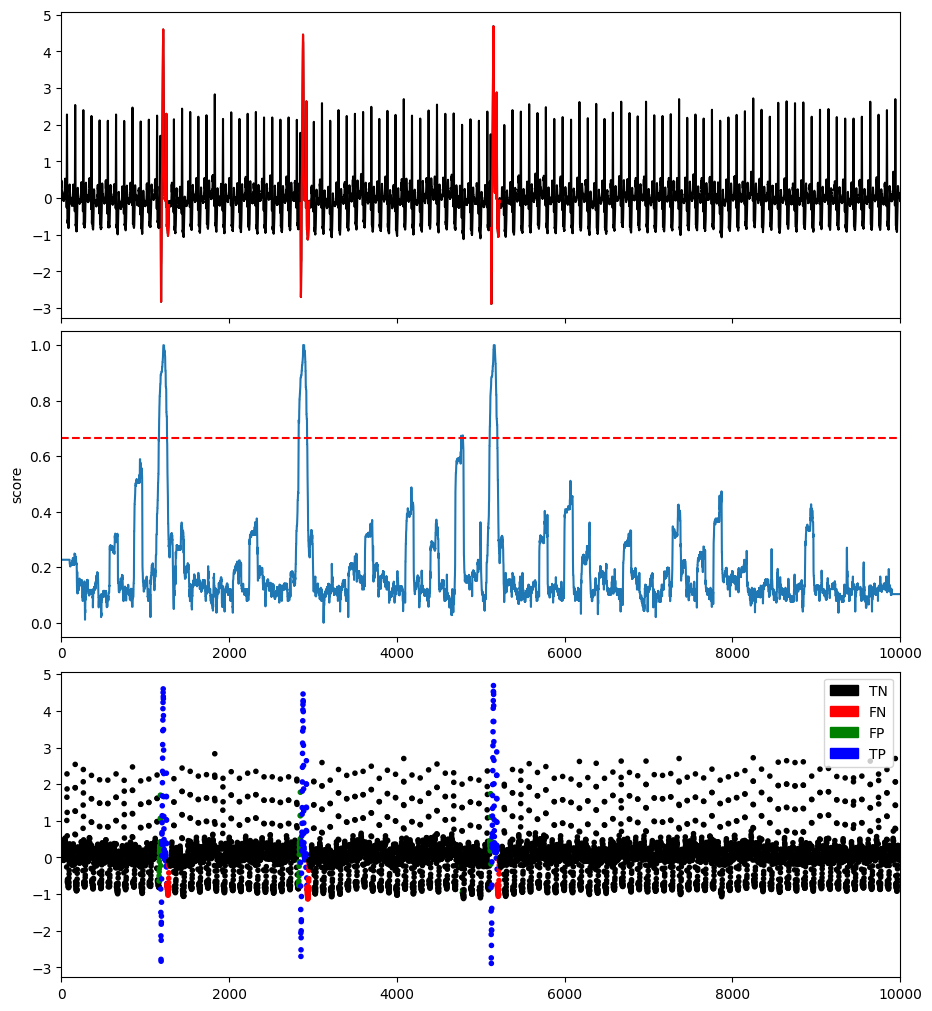

In [7]:
modelName='Series2Graph'
clf = Series2Graph(pattern_length=slidingWindow)
x = data
clf.fit(x)
query_length = slidingWindow*2
clf.score(query_length=query_length,dataset=data)
score = clf.decision_scores_
score = np.array([score[0]]*math.ceil(query_length//2) + list(score) + [score[-1]]*(query_length//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])


AUC_ROC : 0.9685946216566588
AUC_PR : 0.7236739388419061
Precision : 0.7934426229508197
Recall : 0.7986798679867987
F : 0.7960526315789475
Precision_at_k : 0.7986798679867987
Rprecision : 0.7936087839553186
Rrecall : 0.8390176272529214
RF : 0.8156817191123328
R_AUC_ROC : 0.9991473044035373
R_AUC_PR : 0.9793839807828146
VUS_ROC : 0.9952747495853782
VUS_PR : 0.9387433557089315
Affiliation_Precision : 0.9899439614393698
Affiliation_Recall : 0.9985296855185747


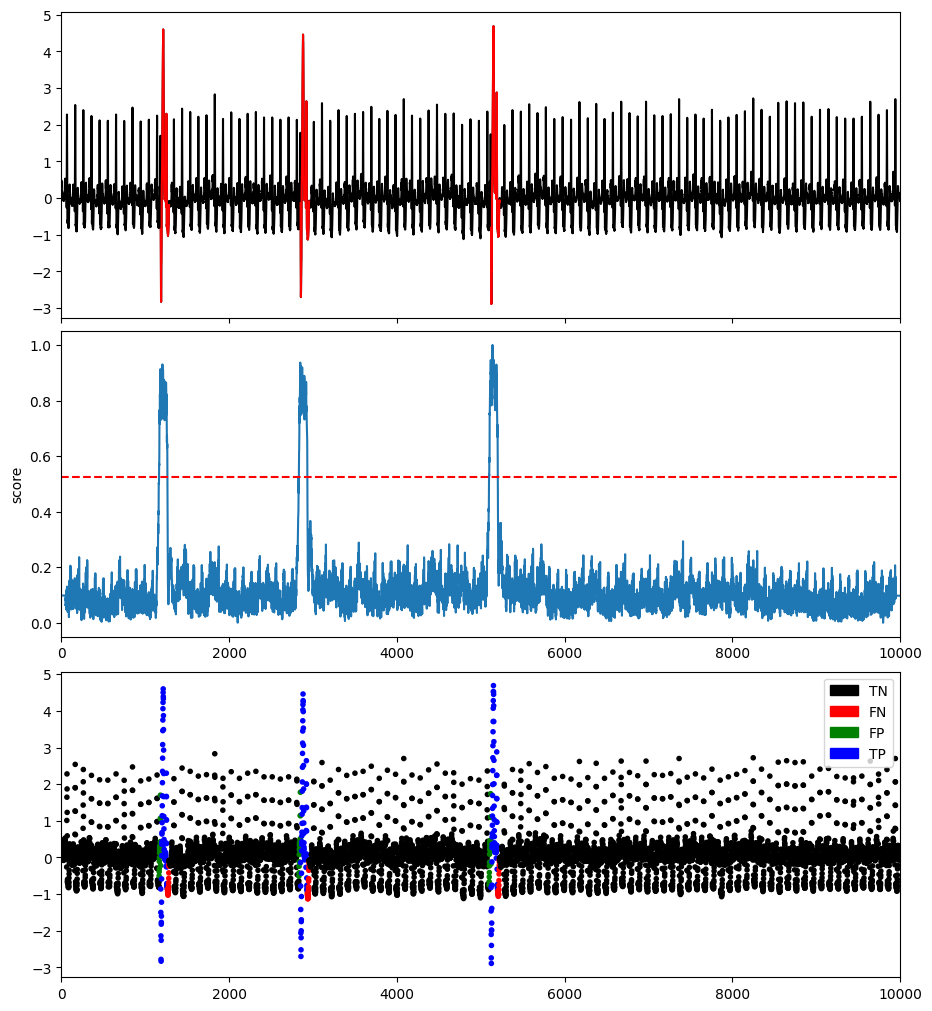

In [7]:
modelName='IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.41096068975774547
AUC_PR : 0.048104473111295544
Precision : 0.21794871794871795
Recall : 0.16831683168316833
F : 0.1899441340782123
Precision_at_k : 0.16831683168316833
Rprecision : 0.3095238095238095
Rrecall : 0.304812834224599
RF : 0.3071502590673575
R_AUC_ROC : 0.6916553096198312
R_AUC_PR : 0.4549204085910081
VUS_ROC : 0.6545868021121983
VUS_PR : 0.35228784121262147
Affiliation_Precision : 0.942248287092041
Affiliation_Recall : 0.978882103900466


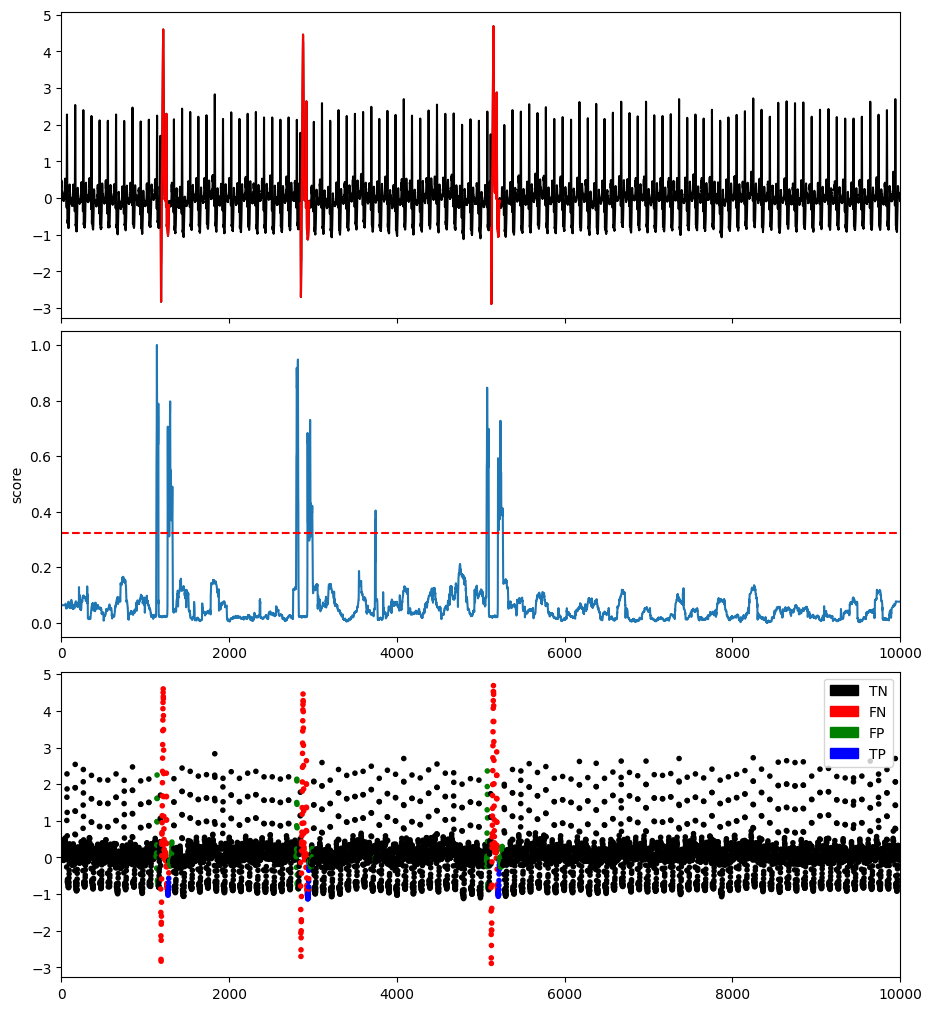

In [8]:
modelName='LOF'
clf = LOF(n_neighbors=20, n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.7968186887782313
AUC_PR : 0.09205761752802392
Precision : 0.058823529411764705
Recall : 0.0297029702970297
F : 0.039473684210526314
Precision_at_k : 0.0297029702970297
Rprecision : 0.125
Rrecall : 0.09090909090909093
RF : 0.10526315789473685
R_AUC_ROC : 0.9531611224056705
R_AUC_PR : 0.4926688922361494
VUS_ROC : 0.9186620929224953
VUS_PR : 0.39033909329157723
Affiliation_Precision : 0.9015749833720904
Affiliation_Recall : 0.9720951147963328


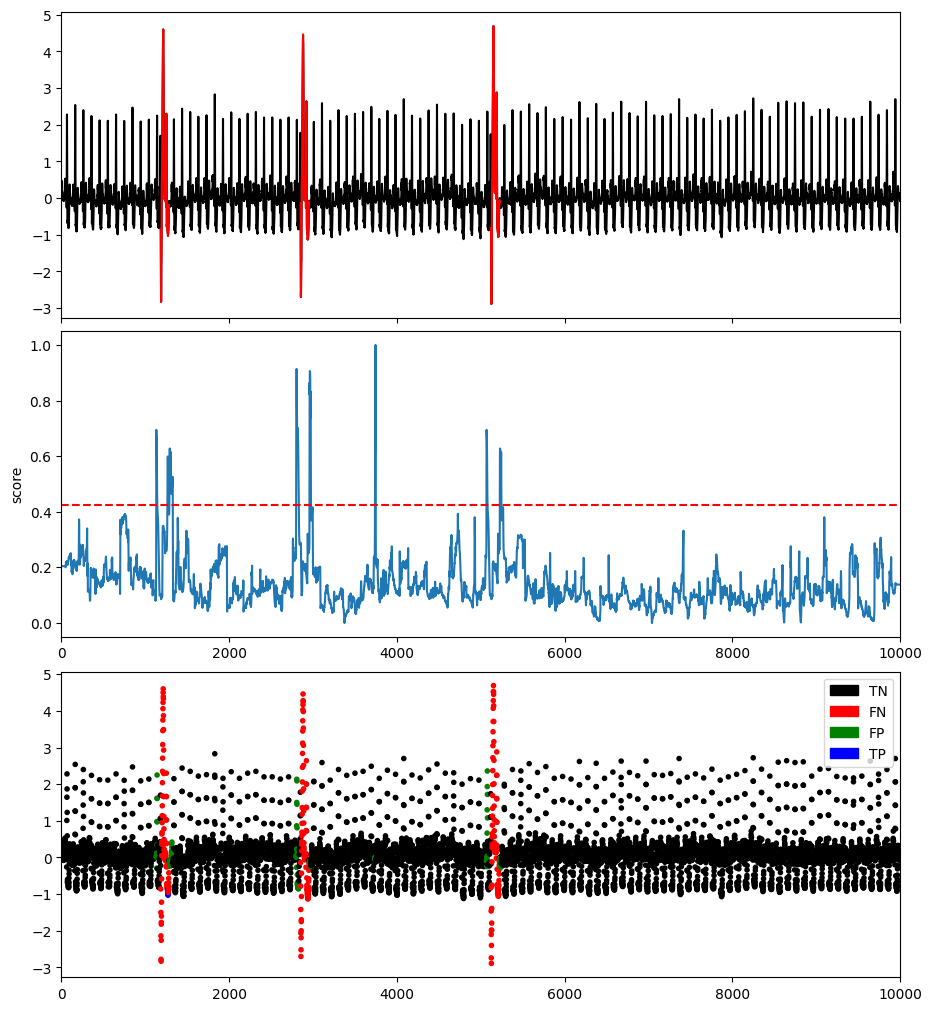

In [9]:
modelName='MatrixProfile'
clf = MatrixProfile(window = slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_

score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

Normal Model Length/number of subsequences selected:  (297, 10)
AUC_ROC : 0.9979623516646807
AUC_PR : 0.932388006170981
Precision : 0.753731343283582
Recall : 1.0
F : 0.8595744680851063
Precision_at_k : 1.0
Rprecision : 0.7537313432835822
Rrecall : 1.0000000000000002
RF : 0.8595744680851066
R_AUC_ROC : 0.9997724221201816
R_AUC_PR : 0.994024737583278
VUS_ROC : 0.999568694352888
VUS_PR : 0.988052538139092
Affiliation_Precision : 0.9812433853440004
Affiliation_Recall : 1.0


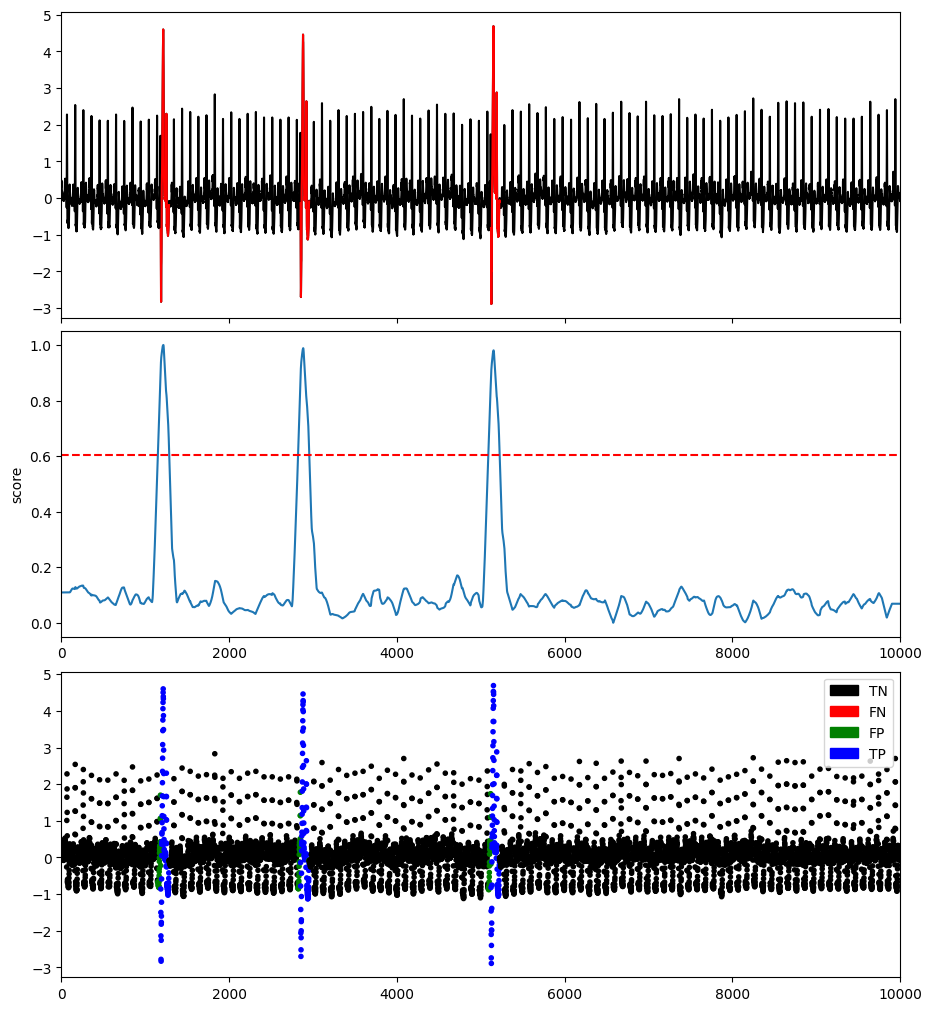

In [11]:
modelName='NORMA'
clf = NORMA(pattern_length = slidingWindow, nm_size=3*slidingWindow)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*((slidingWindow-1)//2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9831757023284056
AUC_PR : 0.7572161269856095
Precision : 0.7752442996742671
Recall : 0.7854785478547854
F : 0.7803278688524591
Precision_at_k : 0.7854785478547854
Rprecision : 0.77530626365804
Rrecall : 0.8284808873044168
RF : 0.8010120555743515
R_AUC_ROC : 0.9994595750446229
R_AUC_PR : 0.9836739288859631
VUS_ROC : 0.997118940672939
VUS_PR : 0.9475589866373976
Affiliation_Precision : 0.9890337001400605
Affiliation_Recall : 0.9982808225194953


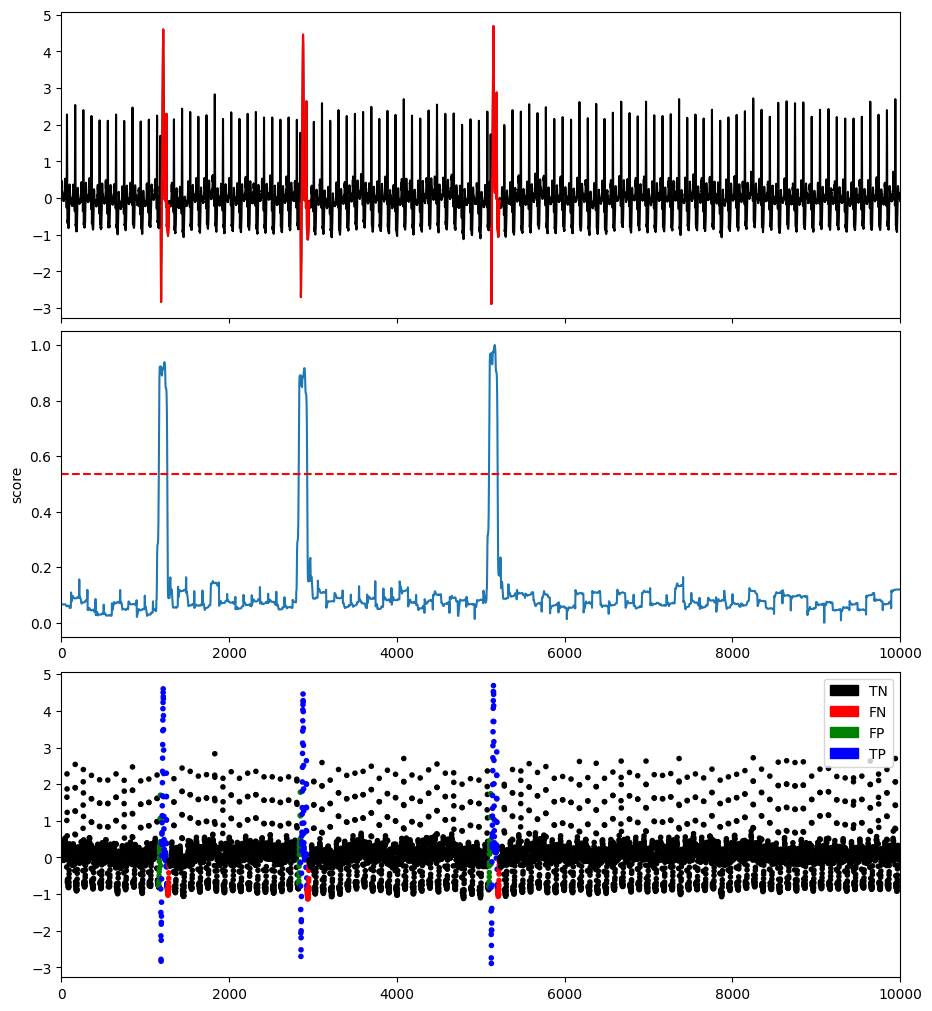

In [10]:
modelName='PCA'
clf = PCA()
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9958617394172128
AUC_PR : 0.8837102941063337
Precision : 0.8686868686868687
Recall : 0.8514851485148515
F : 0.86
Precision_at_k : 0.8514851485148515
Rprecision : 0.8686868686868686
Rrecall : 0.8821944939591999
RF : 0.875388577295774
R_AUC_ROC : 0.9966496859473177
R_AUC_PR : 0.9632279391916059
VUS_ROC : 0.9939772090687404
VUS_PR : 0.9465631009222253
Affiliation_Precision : 0.9810555530560522
Affiliation_Recall : 0.9999934905686477


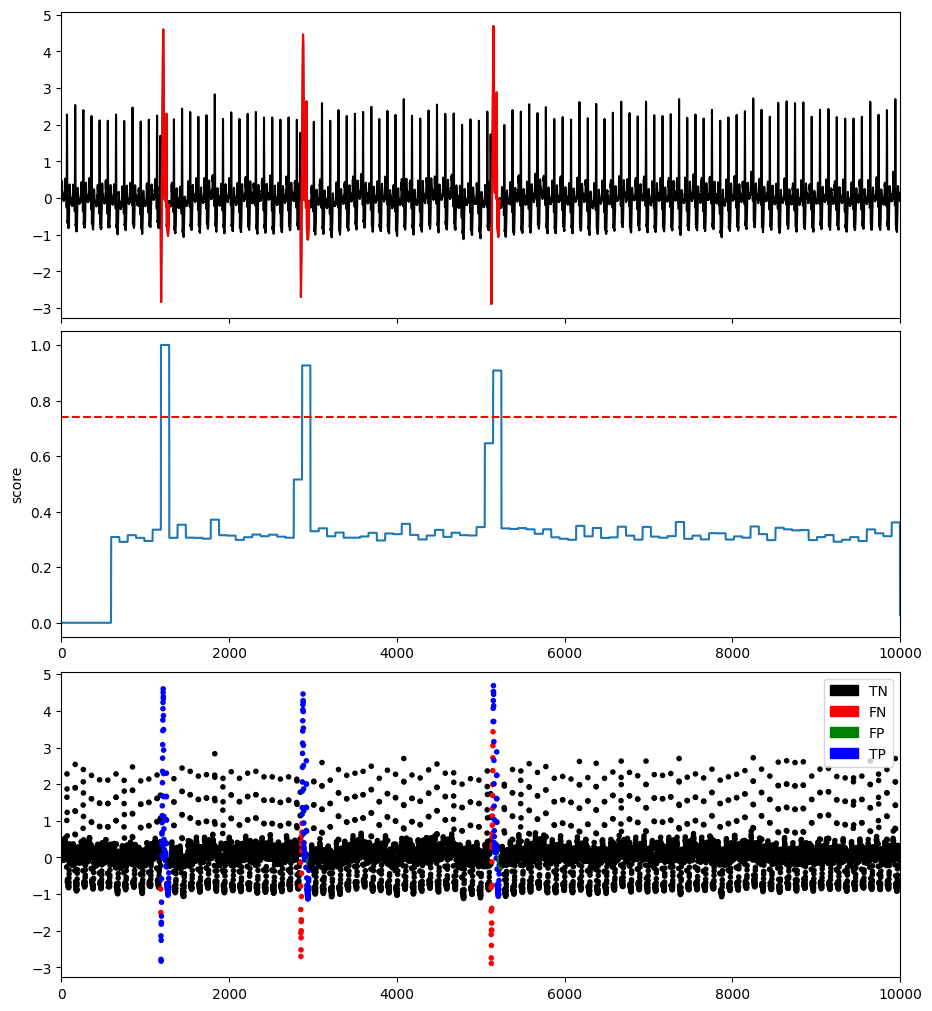

In [11]:
modelName='POLY'
clf = POLY(power=3, window = slidingWindow)
x = data
clf.fit(x)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

AUC_ROC : 0.9416967787322199
AUC_PR : 0.4592289027872978
Precision : 0.6402266288951841
Recall : 0.7458745874587459
F : 0.6890243902439025
Precision_at_k : 0.7458745874587459
Rprecision : 0.4007206588881263
Rrecall : 0.7967914438502675
RF : 0.5332568942659819
R_AUC_ROC : 0.9983442451461604
R_AUC_PR : 0.9119783238745204
VUS_ROC : 0.9905101824629529
VUS_PR : 0.8021253491270806
Affiliation_Precision : 0.9798093961448288
Affiliation_Recall : 0.9970749874410433


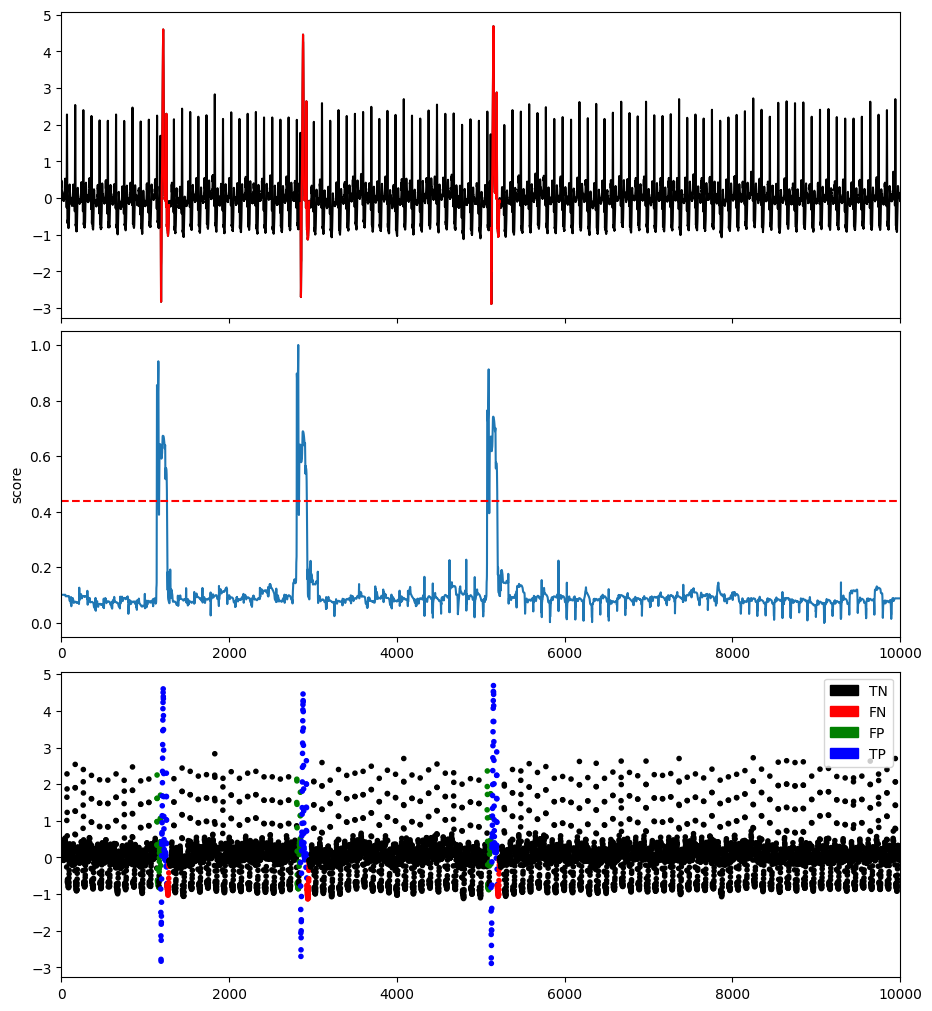

In [12]:
modelName='OCSVM'
X_train_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_train.T).T
X_test_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_test.T).T

clf = OCSVM(nu=0.05)
clf.fit(X_train_, X_test_)


score = clf.decision_scores_
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

310/310 [==============================] - 2s 7ms/step
AUC_ROC : 0.6831383664302287
AUC_PR : 0.120628447738072
Precision : 0.18439716312056736
Recall : 0.1716171617161716
F : 0.17777777777777776
Precision_at_k : 0.1716171617161716
Rprecision : 0.025
Rrecall : 0.3118637353931472
RF : 0.04628930078050358
R_AUC_ROC : 0.7300452172501921
R_AUC_PR : 0.14859987239776568
VUS_ROC : 0.7275909879072169
VUS_PR : 0.1426549169000135
Affiliation_Precision : 0.6036749472429264
Affiliation_Recall : 0.9836496679878174


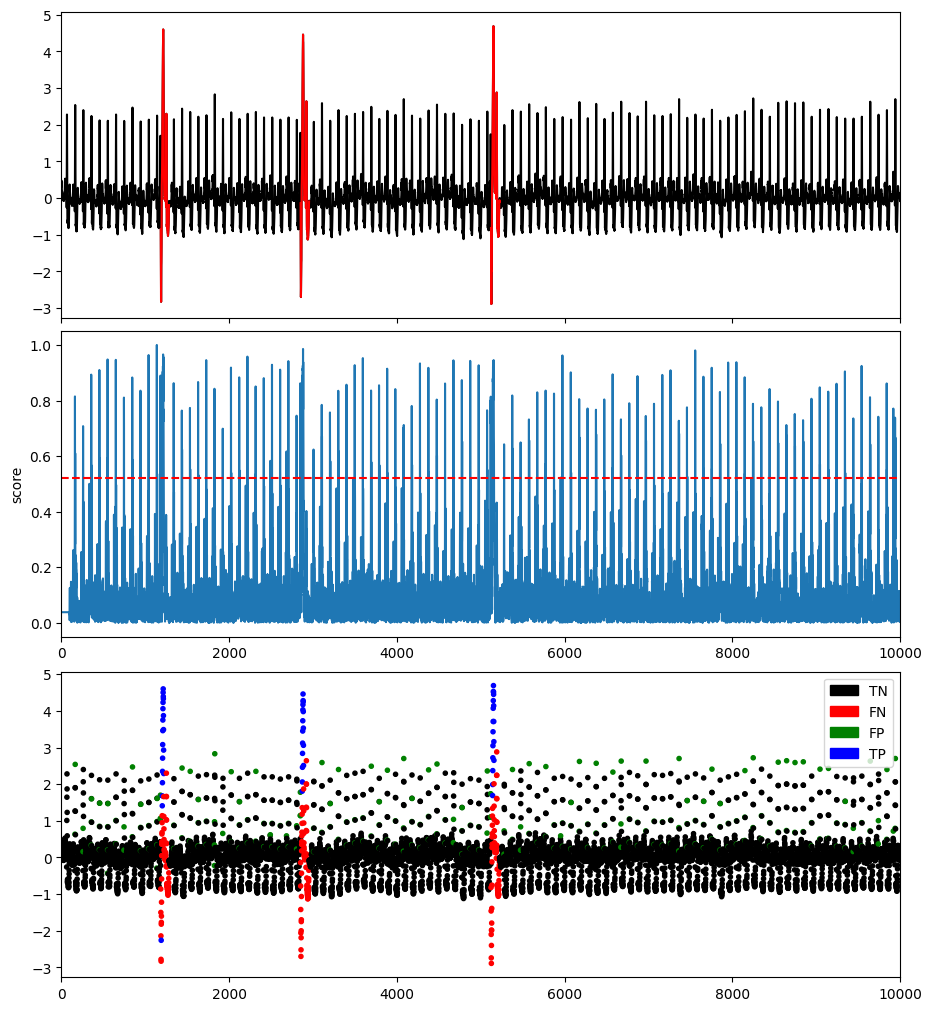

In [13]:
modelName='LSTM'
clf = lstm(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

310/310 [==============================] - 0s 276us/step
AUC_ROC : 0.9798903474961295
AUC_PR : 0.4527029967265067
Precision : 0.6266666666666667
Recall : 0.7755775577557755
F : 0.6932153392330384
Precision_at_k : 0.7755775577557755
Rprecision : 0.7192460317460317
Rrecall : 0.717211328976035
RF : 0.7182272393104755
R_AUC_ROC : 0.9983630797681471
R_AUC_PR : 0.9097203186257167
VUS_ROC : 0.9948961110972894
VUS_PR : 0.7985717813531896
Affiliation_Precision : 0.9784117321775244
Affiliation_Recall : 0.9979366661199016


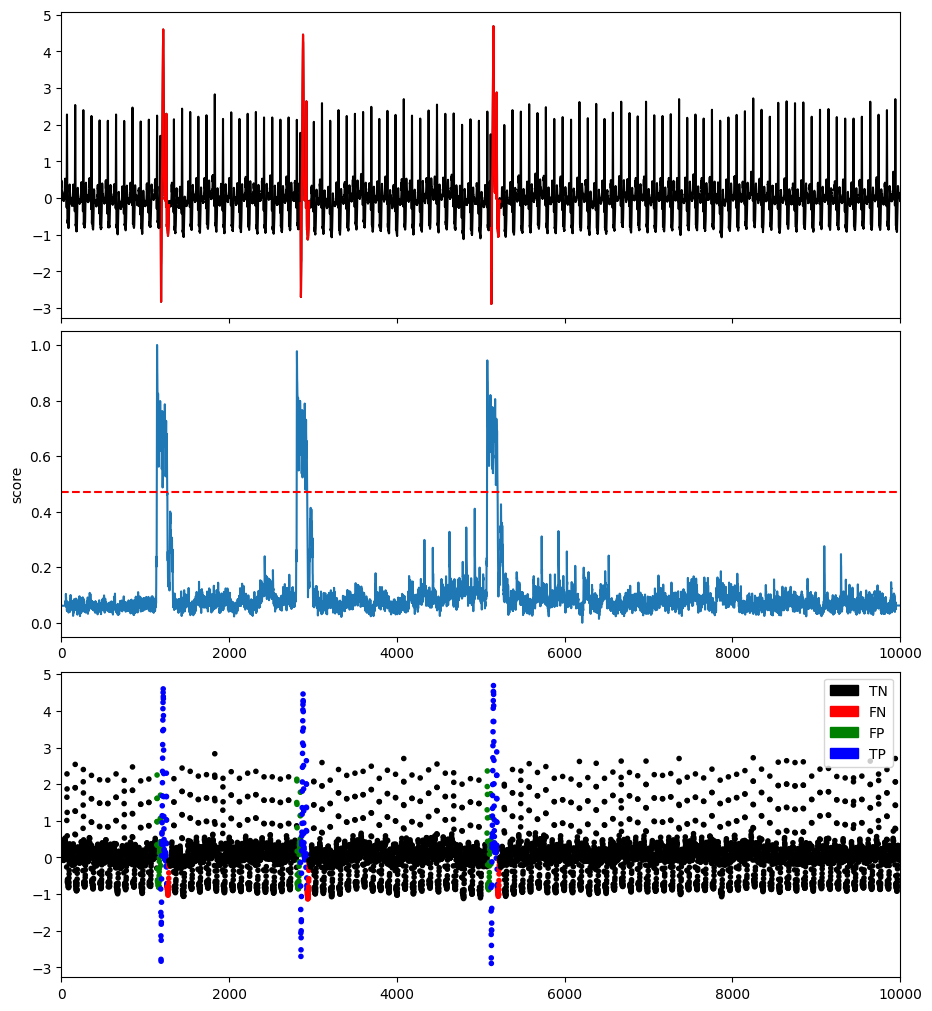

In [14]:
modelName='AE'
clf = AE_MLP2(slidingWindow = slidingWindow, epochs=100, verbose=0)

clf.fit(data_train, data_test)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])

310/310 [==============================] - 0s 461us/step
AUC_ROC : 0.8223519165363994
AUC_PR : 0.3990233632226723
Precision : 0.4337899543378995
Recall : 0.31353135313531355
F : 0.36398467432950193
Precision_at_k : 0.31353135313531355
Rprecision : 0.08823529411764706
Rrecall : 0.32537136066547834
RF : 0.13882386742945993
R_AUC_ROC : 0.8822285204143624
R_AUC_PR : 0.3932986259608648
VUS_ROC : 0.8811101069489891
VUS_PR : 0.4065135625548785
Affiliation_Precision : 0.9128891170124862
Affiliation_Recall : 0.9900155246934222


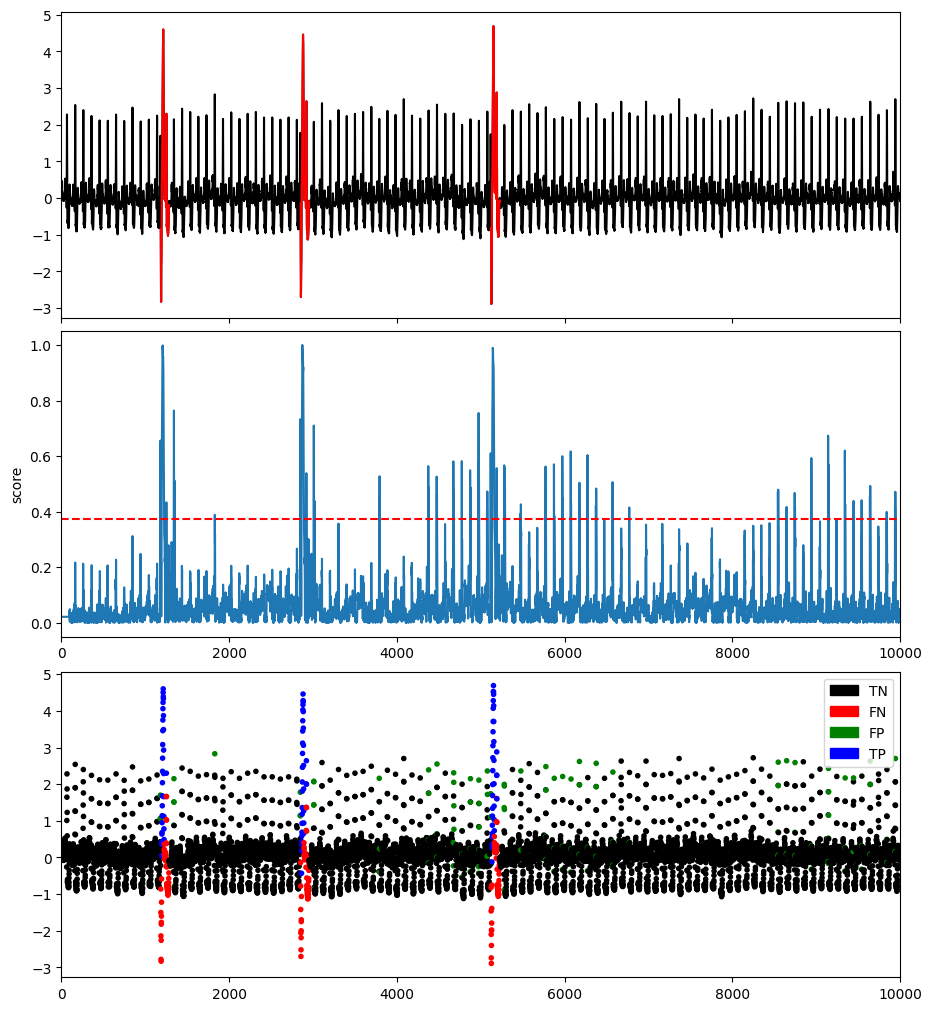

In [15]:
modelName='CNN'
clf = cnn(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 100, patience = 5, verbose=0)

clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

results = get_metrics(score, label, metric="all", slidingWindow=slidingWindow)
for metric in results.keys():
    print(metric, ':', results[metric])